In [1]:
# !pip install trimesh
!pip install --user scikit-misc


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
notebook_dir = os.path.dirname(os.path.abspath(''))
if notebook_dir not in sys.path:
    sys.path.append(os.path.dirname(notebook_dir))
from notebooks.config import *
configure_matplotlib()

# Set figure directory 
SAVE_FIGURES = True
fig_path = SNRNA_FIGURE_DIR
from functools import partial
save_figure = partial(save_figure, dir_path=fig_path)

In [3]:
cpm_scl = CPM_SCL
plt.rcParams["image.cmap"] = CMAP_NAME

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
import scanpy as sc
import pandas as pd
import anndata
from scipy.stats import spearmanr

import processing, utils, plotting, heatmap
import pseudoclusters, test_structures
print(f"scanpy version: {sc.__version__}")

scanpy version: 1.11.3


# Data Loading and Preprocessing

Loading snRNA-seq data...
Data shape: (4895, 1500)
Preparing data for analysis...
Creating UMAP visualization...


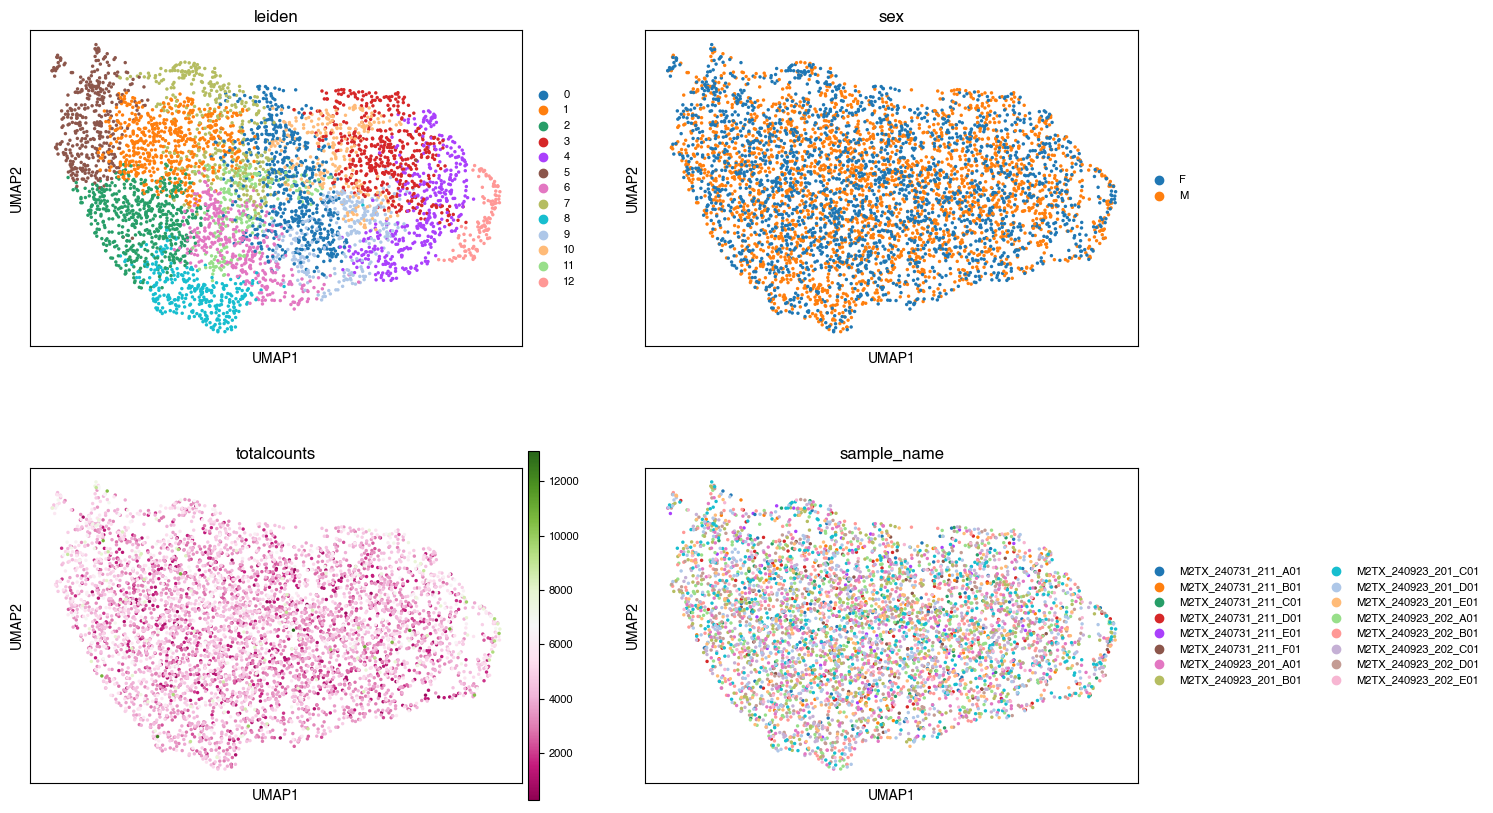

In [7]:
print("Loading snRNA-seq data...")
myfilename = os.path.join(SNRNA_DATA_DIR, "snRNAseq_LCNE_BN_d4_1-5k.h5ad")

adata_foo = sc.read_h5ad(myfilename)
adata_BN = anndata.AnnData(adata_foo.layers['BN'])
adata_BN.obs = adata_foo.obs.copy()
adata_BN.obsm = adata_foo.obsm.copy()
adata_BN.var = adata_foo.var.copy()

print(f"Data shape: {adata_BN.shape}")

# Prepare data for analysis
print("Preparing data for analysis...")
adata_sc = adata_BN.copy()
adata_sc.raw=adata_sc.copy()
sc.pp.scale(adata_sc, zero_center=True, max_value=10)
sc.tl.pca(adata_sc, n_comps=50, svd_solver='arpack')

# Basic UMAP visualization
print("Creating UMAP visualization...")
ax = sc.pl.umap(
    adata_sc, 
    color=["leiden", "sex", 'totalcounts', 'sample_name'],
    ncols=2,
    show=False
)
for a in ax:
    a.set_aspect('equal')
# save_figure("umap_basic")

# PCA Exploratory Analysis

Exploring PCA dimensions...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions.png


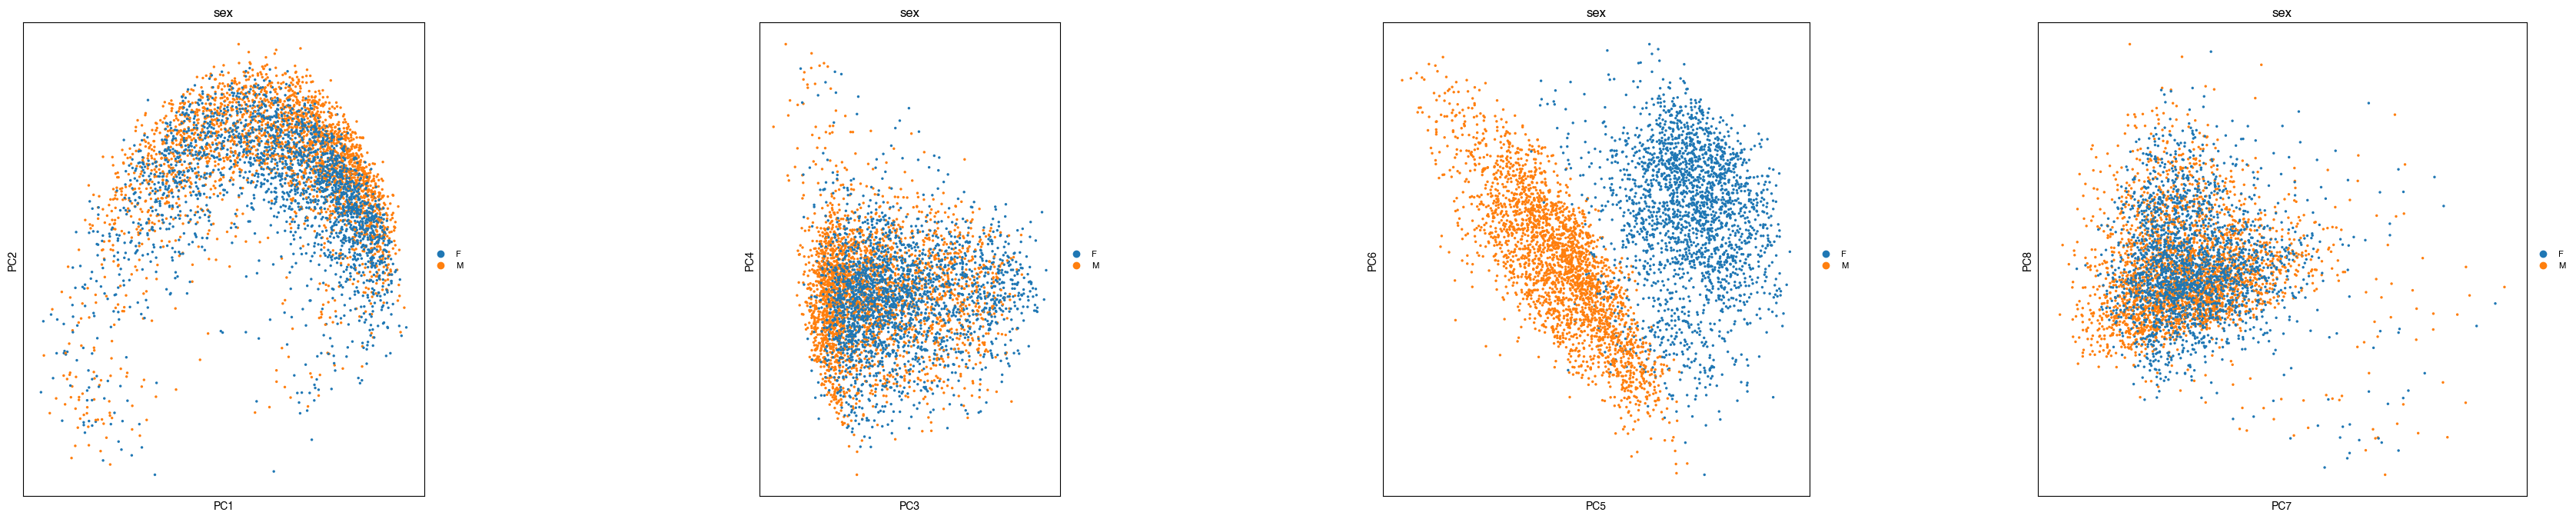

In [8]:
# PCA Exploratory Analysis
print("Exploring PCA dimensions...")

# Plot first few PCA dimensions
with plt.rc_context({"figure.figsize": (10, 8)}):    
    ax = sc.pl.pca(adata_sc, dimensions=((0, 1), (2, 3), (4, 5), (6, 7)), 
                  show=False, color='sex')
    for a in ax: 
        a.set_aspect('equal')
    save_figure("pca_dimensions")
    plt.show()


# Trajectory Analysis with Pseudoclusters


Performing trajectory analysis with pseudoclusters...
Using 10 PCA dimensions explaining 0.439 of variance
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_pc1_pc2.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_pc1_pc2.png


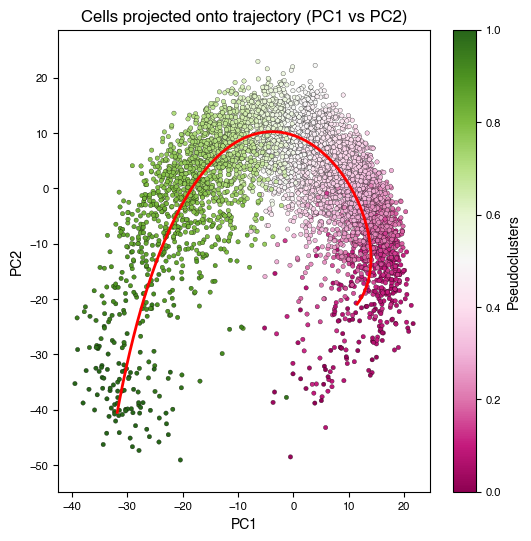

Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_pc2_pc3.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_pc2_pc3.png


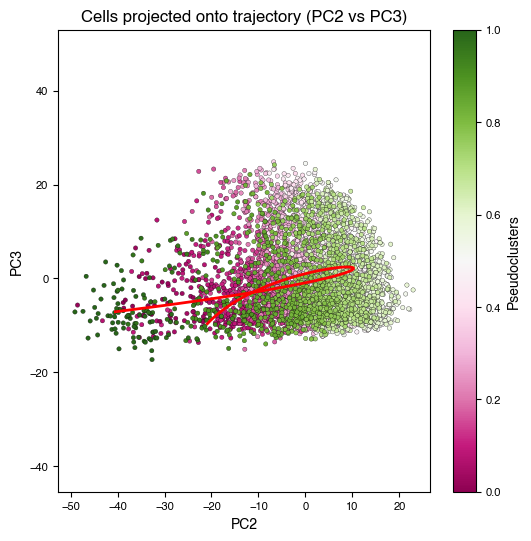

In [9]:
# Trajectory Analysis with Pseudoclusters
print("Performing trajectory analysis with pseudoclusters...")

# Set dimensionality for trajectory analysis
n_dims = 10
print(f"Using {n_dims} PCA dimensions explaining {adata_sc.uns['pca']['variance_ratio'][:n_dims].sum():.3f} of variance")

# Fit trajectory curve and calculate projections
trajectory = pseudoclusters.fit_trajectory_curve(adata_sc, deg=3, n_dims=n_dims)
projections = pseudoclusters.calculate_projection_scores(trajectory, n_points=10000)

# Ensure pseudocluster scores are oriented correctly (0 at one end, 1 at other end)
if projections['scores'][0] < 0.5:  # keep the original order!
    scores_0_1 = projections['scores']
else:
    scores_0_1 = 1 - projections['scores']
fittedcurve = projections['fitted_curve']

# Visualize projections in PCA space
data = adata_sc.obsm['X_pca'][trajectory['order'], :n_dims]

# PC1 vs PC2
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=10, c=scores_0_1, 
            edgecolor='k', linewidth=0.2, cmap=CMAP_NAME)
plt.plot(fittedcurve[0], fittedcurve[1], 'r-', lw=2)
plt.colorbar(label='Pseudoclusters')
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cells projected onto trajectory (PC1 vs PC2)')
save_figure("pseudocluster_pc1_pc2", dir_path=fig_path)
plt.show()

# PC2 vs PC3
i = 1; j = 2
plt.figure(figsize=(6, 6))
plt.scatter(data[:, i], data[:, j], s=10, c=scores_0_1, 
            edgecolor='k', linewidth=0.2, cmap=CMAP_NAME)
plt.plot(fittedcurve[i], fittedcurve[j], 'r-', lw=2)
plt.colorbar(label='Pseudoclusters')
plt.axis('equal')
plt.xlabel(f'PC{i+1}')
plt.ylabel(f'PC{j+1}')
plt.title(f'Cells projected onto trajectory (PC{i+1} vs PC{j+1})')
save_figure("pseudocluster_pc2_pc3", dir_path=fig_path)
plt.show()

# visualize 3D

Creating 3D visualizations of trajectory...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_default.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_default.png
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_front.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_front.png
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_top.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_top.png
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_custom.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_3d_custom.png


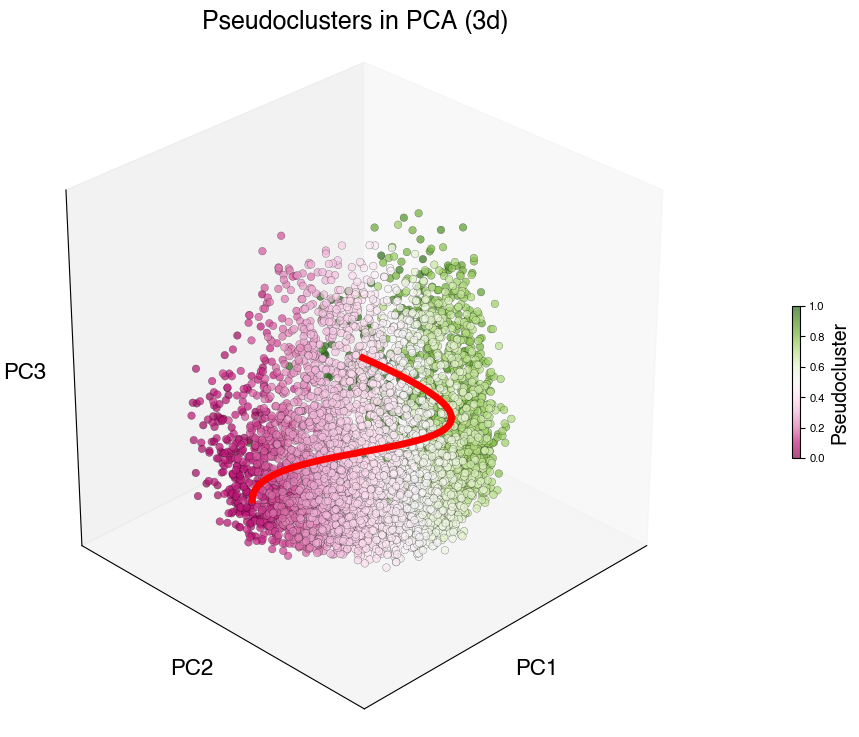

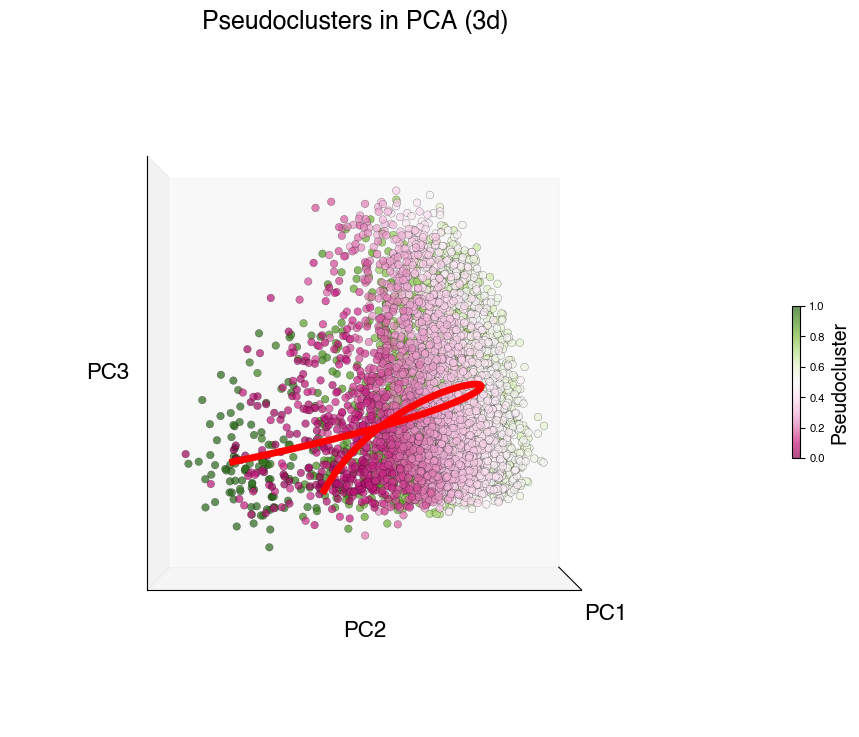

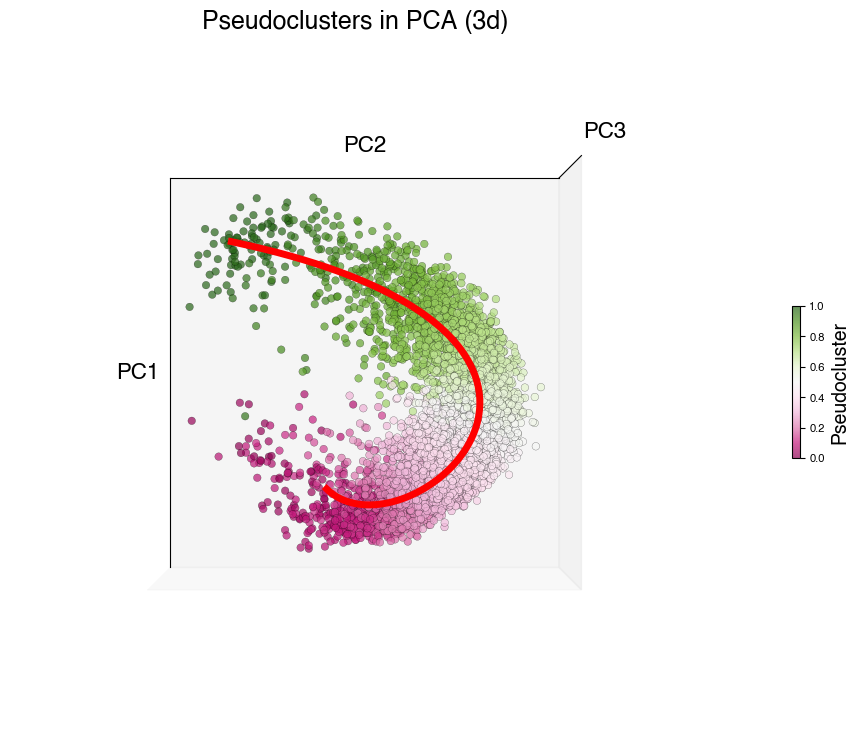

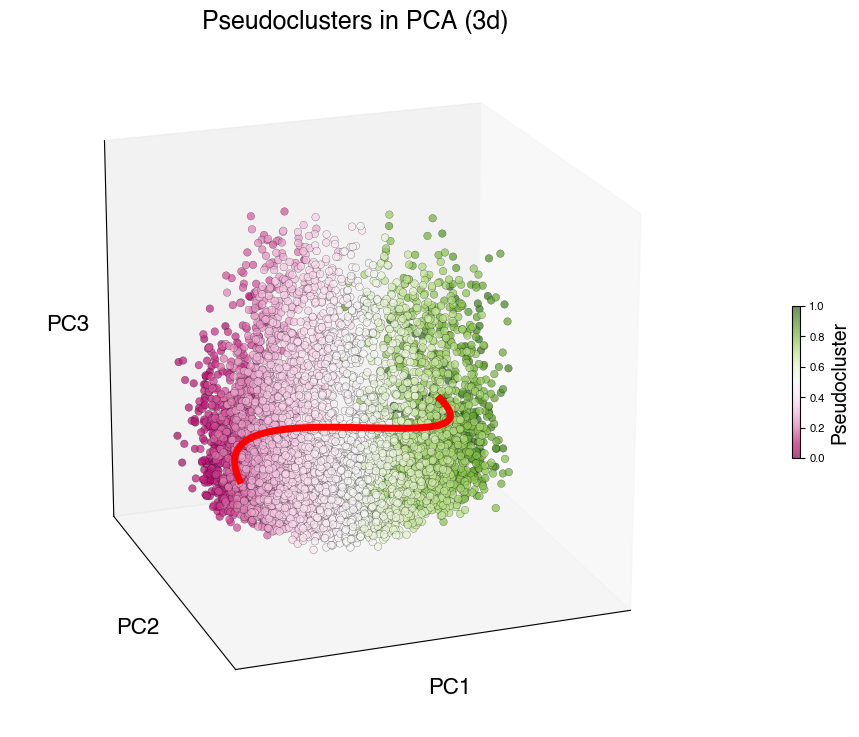

In [10]:
# 3D Visualization of Trajectory
print("Creating 3D visualizations of trajectory...")

# Create 3D plots from different angles
fig1 = pseudoclusters.plot_trajectory_3d(trajectory, projections)  # Default angles
save_figure("trajectory_3d_default", dir_path=fig_path)

fig2 = pseudoclusters.plot_trajectory_3d(trajectory, projections, elev=0, azim=0)  # Front view
save_figure("trajectory_3d_front", dir_path=fig_path)

fig3 = pseudoclusters.plot_trajectory_3d(trajectory, projections, elev=90, azim=0)  # Top-down view
save_figure("trajectory_3d_top", dir_path=fig_path)

fig4 = pseudoclusters.plot_trajectory_3d(trajectory, projections, elev=20, azim=70)  # Custom angle
save_figure("trajectory_3d_custom", dir_path=fig_path)

# Bootstrap Analysis of Trajectory Robustness

Performing bootstrap analysis of trajectory robustness...
Generating 100 bootstrap samples...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_bootstrap_std.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_bootstrap_std.png


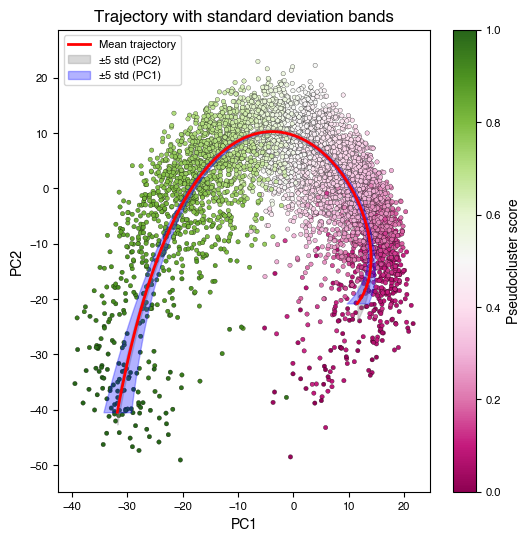

In [11]:
# Bootstrap Analysis of Trajectory Robustness
print("Performing bootstrap analysis of trajectory robustness...")

# Set up bootstrap parameters
std_scl = 5  # Standard deviation scale for visualization
trajectory = pseudoclusters.fit_trajectory_curve(adata_sc, deg=3, n_dims=n_dims)
projections = pseudoclusters.calculate_projection_scores(trajectory, n_points=1000)
data = adata_sc.obsm['X_pca'][trajectory['order'], :n_dims]
t_proj = trajectory['t_proj']
t_lin = projections['t_grid']
n_boot = 100

# Perform bootstrap sampling
print(f"Generating {n_boot} bootstrap samples...")
boot_curves = np.zeros((n_boot, len(t_lin), n_dims))
for i in range(n_boot):
    idx = np.random.choice(len(data), len(data), replace=True)
    data_bs = data[idx]
    t_bs = t_proj[idx]
    for d in range(n_dims):
        p = np.polyfit(t_bs, data_bs[:, d], 3)
        boot_curves[i, :, d] = np.polyval(p, t_lin)

# Calculate statistics
mean_curve = boot_curves.mean(axis=0)   # shape (n_t, n_dims)
std_curve = boot_curves.std(axis=0)    # shape (n_t, n_dims)

# Plot with standard deviation bands
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=10, c=projections['scores'],
            edgecolor='k', linewidth=0.2, cmap=CMAP_NAME)
plt.plot(mean_curve[:, 0], mean_curve[:, 1], 'r-', lw=2, label='Mean trajectory')

# PC2-variance band: vertical band around the curve in y
plt.fill_between(mean_curve[:, 0],
                 mean_curve[:, 1] - std_scl*std_curve[:, 1],
                 mean_curve[:, 1] + std_scl*std_curve[:, 1],
                 color='gray', alpha=0.3,
                 label=f'±{std_scl} std (PC2)')

# PC1-variance band: horizontal band around the curve in x
plt.fill_betweenx(mean_curve[:, 1],
                  mean_curve[:, 0] - std_scl*std_curve[:, 0],
                  mean_curve[:, 0] + std_scl*std_curve[:, 0],
                  color='blue', alpha=0.3,
                  label=f'±{std_scl} std (PC1)')

plt.colorbar(label='Pseudocluster score')
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.title('Trajectory with standard deviation bands')
save_figure("trajectory_bootstrap_std", dir_path=fig_path)
plt.show()

Computing 95% confidence intervals from bootstrap...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_bootstrap_ci.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/trajectory_bootstrap_ci.png


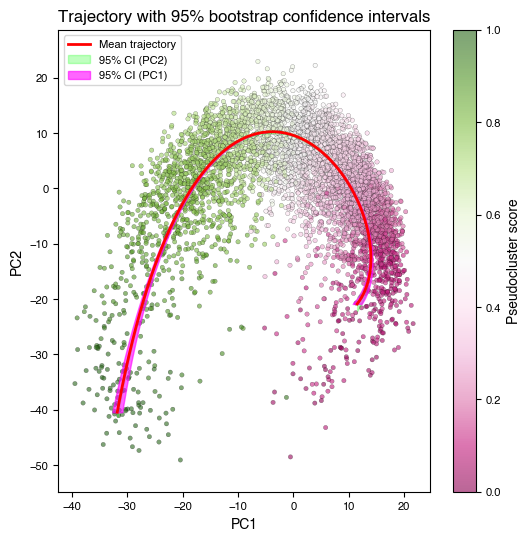

In [12]:
# Confidence Interval Analysis
print("Computing 95% confidence intervals from bootstrap...")

# Perform more thorough bootstrap with 10,000 samples for accurate CIs
n_boot = 10000
boot_curves = np.zeros((n_boot, len(t_lin), n_dims))
for i in range(n_boot):
    idx = np.random.choice(len(data), len(data), replace=True)
    data_bs = data[idx]
    t_bs = t_proj[idx]
    for d in range(n_dims):
        p = np.polyfit(t_bs, data_bs[:, d], 3)
        boot_curves[i, :, d] = np.polyval(p, t_lin)

# Compute percentiles for 95% CI
ci_lower = np.percentile(boot_curves, 2.5, axis=0)   # shape (n_t, n_dims)
ci_upper = np.percentile(boot_curves, 97.5, axis=0)  # shape (n_t, n_dims)
mean_curve = boot_curves.mean(axis=0)

# Plot with confidence intervals
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=10, c=projections['scores'],
            edgecolor='k', linewidth=0.2, cmap=CMAP_NAME, alpha=0.6)
plt.plot(mean_curve[:, 0], mean_curve[:, 1], 'r-', lw=2, label='Mean trajectory')

# PC2 95% CI band (vertical shading)
plt.fill_between(mean_curve[:, 0],
                 ci_lower[:, 1],
                 ci_upper[:, 1],
                 color='lime', alpha=0.25,
                 label='95% CI (PC2)')

# PC1 95% CI band (horizontal shading)
plt.fill_betweenx(mean_curve[:, 1],
                  ci_lower[:, 0],
                  ci_upper[:, 0],
                  color='magenta', alpha=0.6,
                  label='95% CI (PC1)')

plt.colorbar(label='Pseudocluster score')
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Trajectory with 95% bootstrap confidence intervals')
plt.legend(loc='best')
save_figure("trajectory_bootstrap_ci")
plt.show()

# Clean Visualization of Pseudoclusters

Creating publication-quality pseudocluster visualization...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_pca_clean.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_pca_clean.png


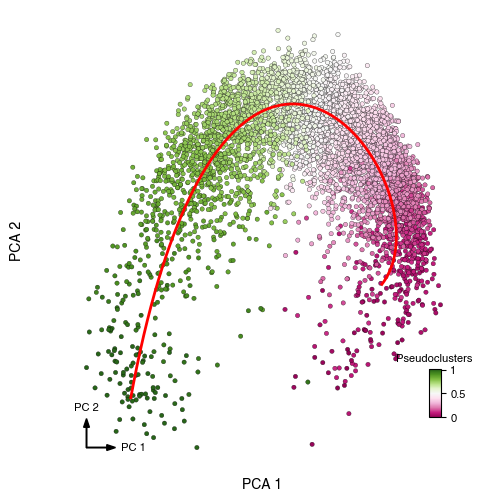

Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_distance.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_distance.png


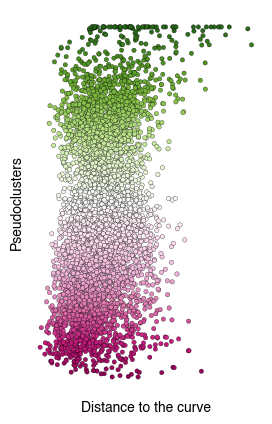

In [13]:
# Clean Visualization of Pseudoclusters
print("Creating publication-quality pseudocluster visualization...")

fs = 8  # Font size for labels
s = 10  # Point size for scatter
yourtitlename = 'Pseudoclusters'

# Create main PCA visualization
plt.figure(figsize=(6, 6))
plt.plot(fittedcurve[0], fittedcurve[1], 'r-', lw=2)
sca = plt.scatter(data[:, 0], data[:, 1], s=s, c=scores_0_1, 
                  edgecolor='k', linewidth=0.2, cmap=CMAP_NAME)
plt.axis('equal')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Add coordinate system arrows
x0, y0 = np.min(adata_sc.obsm['X_pca'], 0)[:2]
plt.arrow(x0, y0, 5, 0,
         head_width=1, width=0.1,
         length_includes_head=True, color='black')
plt.arrow(x0, y0, 0, 5,
         head_width=1, width=0.1,
         length_includes_head=True, color='black')

plt.text(x0+6, y0, 'PC 1', va='center', ha='left', fontsize=fs)
plt.text(x0, y0+6, 'PC 2', va='bottom', ha='center', fontsize=fs)

# Clean up plot appearance
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Add custom colorbar
cbar_ax = plt.gcf().add_axes([0.79, 0.20, 0.02, 0.08])
plt.gcf().colorbar(sca, cax=cbar_ax, ticks=[0.01, 0.5, 0.99])
cbar_ax.set_yticklabels(['0', '0.5', '1'])  # vertically oriented colorbar
cbar_ax.set_title(yourtitlename, fontsize=fs)
cbar_ax.tick_params(labelsize=fs)

save_figure("pseudocluster_pca_clean")
plt.show()

# Create distance scatter plot
plt.figure(figsize=(3, 5))
sca = plt.scatter(np.sqrt(projections['min_d2']), scores_0_1, 
                  c=scores_0_1, edgecolor='k', linewidth=0.2, s=s, cmap=CMAP_NAME)
plt.ylabel(yourtitlename)
plt.xlabel('Distance to the curve')

# Clean up plot appearance
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

save_figure("pseudocluster_distance")
plt.show()

In [14]:
# Save Pseudocluster Scores for External Use
print("Saving pseudocluster scores to CSV...")

# Create array with original cell ordering
scores_01_orig = np.empty_like(scores_0_1)
scores_01_orig[trajectory['order']] = scores_0_1

# Create dataframe and save to CSV
cellID_pc = pd.DataFrame({'cellID': adata_sc.obs.index, 'pseudoclusters': scores_01_orig})
output_file = os.path.join(os.path.dirname(TMP_OUT_DIR), 'cellID_pc_0722.csv')
cellID_pc.to_csv(output_file, index=False)
print(f"Saved pseudocluster scores to: {output_file}")

Saving pseudocluster scores to CSV...
Saved pseudocluster scores to: /root/capsule/lcne_transcriptomics/cellID_pc_0722.csv


Visualizing pseudoclusters on UMAP...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_umap.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pseudocluster_umap.png


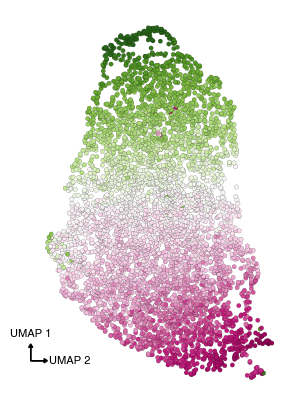

In [15]:
# Visualize Pseudoclusters on UMAP
print("Visualizing pseudoclusters on UMAP...")

plt.figure(figsize=(7, 5))
ax = plt.gca()
sca = ax.scatter(
    adata_sc.obsm['X_umap'][trajectory['order'], 1],
    adata_sc.obsm['X_umap'][trajectory['order'], 0],
    s=s, c=scores_0_1, cmap=CMAP_NAME, edgecolor='k', linewidth=0.1
)

# Clean up plot appearance
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add coordinate system arrows
x0, y0 = np.min(adata_sc.obsm['X_umap'], 0)
ax.arrow(x0, y0, 1, 0, head_width=0.25, head_length=0.2,
         length_includes_head=True, width=0.001, color='black')
ax.arrow(x0, y0, 0, 1, head_width=0.25, head_length=0.2,
         length_includes_head=True, width=0.001, color='black')

ax.text(x0+1.1, y0, 'UMAP 2', va='center', ha='left', fontsize=fs)
ax.text(x0, y0+1.3, 'UMAP 1', va='bottom', ha='center', fontsize=fs)
ax.set_aspect('equal')

save_figure("pseudocluster_umap")
plt.show()

In [16]:
# Find Genes Correlated with Pseudoclusters
print("Finding genes correlated with pseudoclusters...")

# Calculate correlations between gene expression and pseudocluster scores
if hasattr(adata_sc.X, 'toarray'):
    expr = adata_sc.X.toarray()
else:
    expr = adata_sc.X

correlations = []
p_values = []
for i in range(expr.shape[1]):
    gene_expr = expr[:, i][trajectory['order']]
    r, p = spearmanr(scores_0_1, gene_expr)
    correlations.append(r)
    p_values.append(p)

correlations = np.array(correlations)
p_values = np.array(p_values)

# Create DataFrame of results
df = pd.DataFrame({
    'gene': adata_sc.var_names,
    'correlation': correlations,
    'p_value': p_values
})

# Sort by correlation strength
df_sorted = df.iloc[np.argsort(np.abs(df['correlation']))[::-1]]
print("Top 10 genes correlated with pseudoclusters:")
print(df_sorted.head(10))

# Extract positive and negative correlated genes
posgenes = df.iloc[np.argsort((df['correlation']))[::-1]][:30]['gene']
neggenes = df.iloc[np.argsort((df['correlation']))][:30]['gene']

# Add u-shaped genes (genes with non-linear patterns)
u_genes = ['Lrrtm4', 'Vwc2', 'Sgcz', 'Mcc', 'Grik1', 'Pitpnc1', 'Lhfpl3']

Finding genes correlated with pseudoclusters...
Top 10 genes correlated with pseudoclusters:
        gene  correlation  p_value
608    Epha6     0.940616      0.0
909    Chsy3    -0.926096      0.0
979     Dab1    -0.902570      0.0
462     Fat3    -0.902220      0.0
551    Htr2c     0.899379      0.0
94     Lrrc7     0.885942      0.0
1042   Alcam     0.884097      0.0
127    Ncam2     0.882992      0.0
1461    Gpc6    -0.874793      0.0
288   Thsd7b    -0.873959      0.0


Visualizing gene expression patterns on UMAP...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_patterns_umap.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_patterns_umap.png


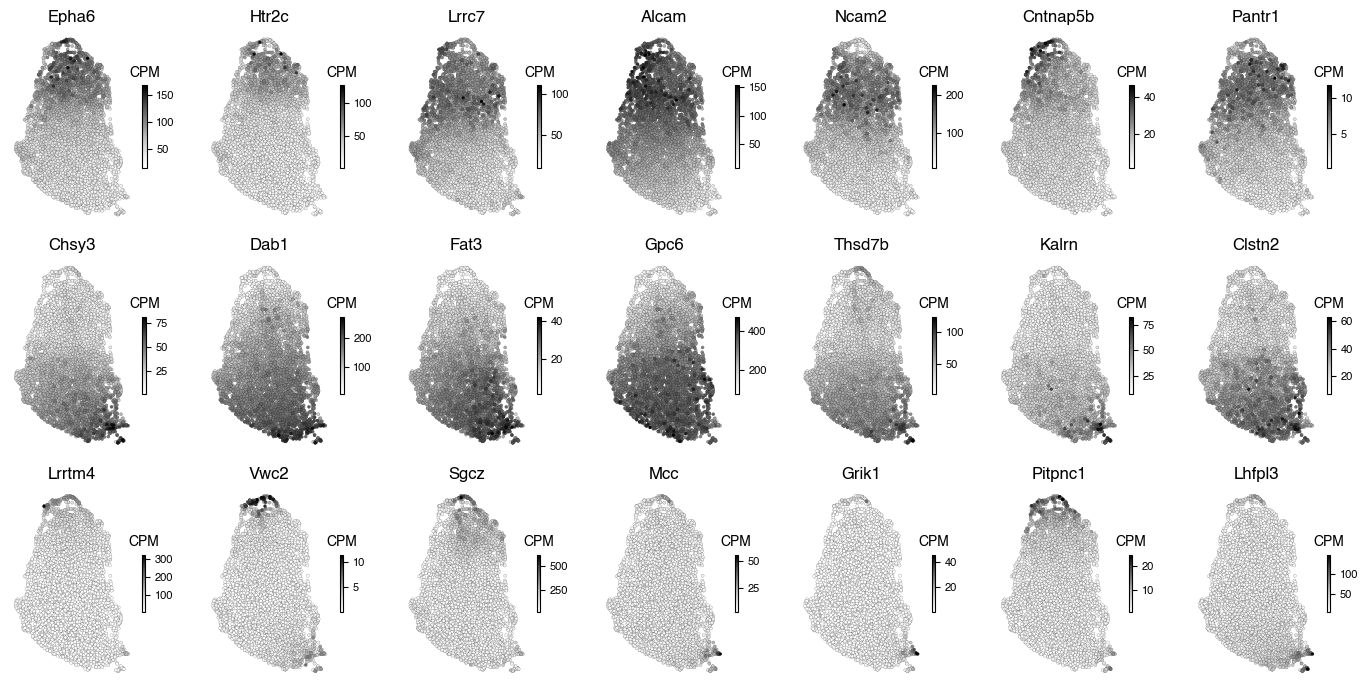

In [17]:
# Visualize Gene Expression Patterns on UMAP
print("Visualizing gene expression patterns on UMAP...")

T = len(u_genes)
s = 5
fig, axes = plt.subplots(3, T, figsize=(2*T, 7))

# Plot positive, negative, and u-shaped genes
for t in range(T):
    # Positive correlation genes
    ax = axes[0, t]
    expr = adata_sc[:, list(posgenes)[t]].X.toarray().flatten()
    expr_order = np.argsort(expr)
    ax.set_title(list(posgenes)[t])
    sca = ax.scatter(
        adata_sc.obsm['X_umap'][expr_order, 1],
        adata_sc.obsm['X_umap'][expr_order, 0],
        c=adata_sc.raw.X[expr_order,np.where(adata_sc.var_names==list(posgenes)[t])[0][0]]*cpm_scl,
        s=s, cmap='Greys',
        edgecolor='k', linewidth=0.1
    )
    ax.set_aspect('equal')
    cbar = plt.colorbar(sca, shrink=0.43, orientation='vertical')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("CPM", ha='center', va='bottom')
    
    # Clean up appearance
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Negative correlation genes
    ax = axes[1, t]
    expr = adata_sc[:, list(neggenes)[t]].X.toarray().flatten()
    expr_order = np.argsort(expr)
    ax.set_title(list(neggenes)[t])
    sca = ax.scatter(
        adata_sc.obsm['X_umap'][expr_order, 1],
        adata_sc.obsm['X_umap'][expr_order, 0],
        c=adata_sc.raw.X[expr_order,np.where(adata_sc.var_names==list(neggenes)[t])[0][0]]*cpm_scl,
        s=s, cmap='Greys',
        edgecolor='k', linewidth=0.1
    )
    ax.set_aspect('equal')
    cbar = plt.colorbar(sca, shrink=0.4, orientation='vertical')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("CPM", ha='center', va='bottom')
    
    # Clean up appearance
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # U-shaped genes
    ax = axes[2, t]
    expr = adata_sc[:, list(u_genes)[t]].X.toarray().flatten()
    expr_order = np.argsort(expr)
    ax.set_title(list(u_genes)[t])
    sca = ax.scatter(
        adata_sc.obsm['X_umap'][expr_order, 1],
        adata_sc.obsm['X_umap'][expr_order, 0],
        c=adata_sc.raw.X[expr_order,np.where(adata_sc.var_names==list(u_genes)[t])[0][0]]*cpm_scl,
        s=s, cmap='Greys',
        edgecolor='k', linewidth=0.1
    )
    ax.set_aspect('equal')
    cbar = plt.colorbar(sca, shrink=0.3, orientation='vertical')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("CPM", ha='center', va='bottom')
    
    # Clean up appearance
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
save_figure("gene_patterns_umap")
plt.show()

Visualizing gene expression patterns on PCA...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_patterns_pca.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_patterns_pca.png


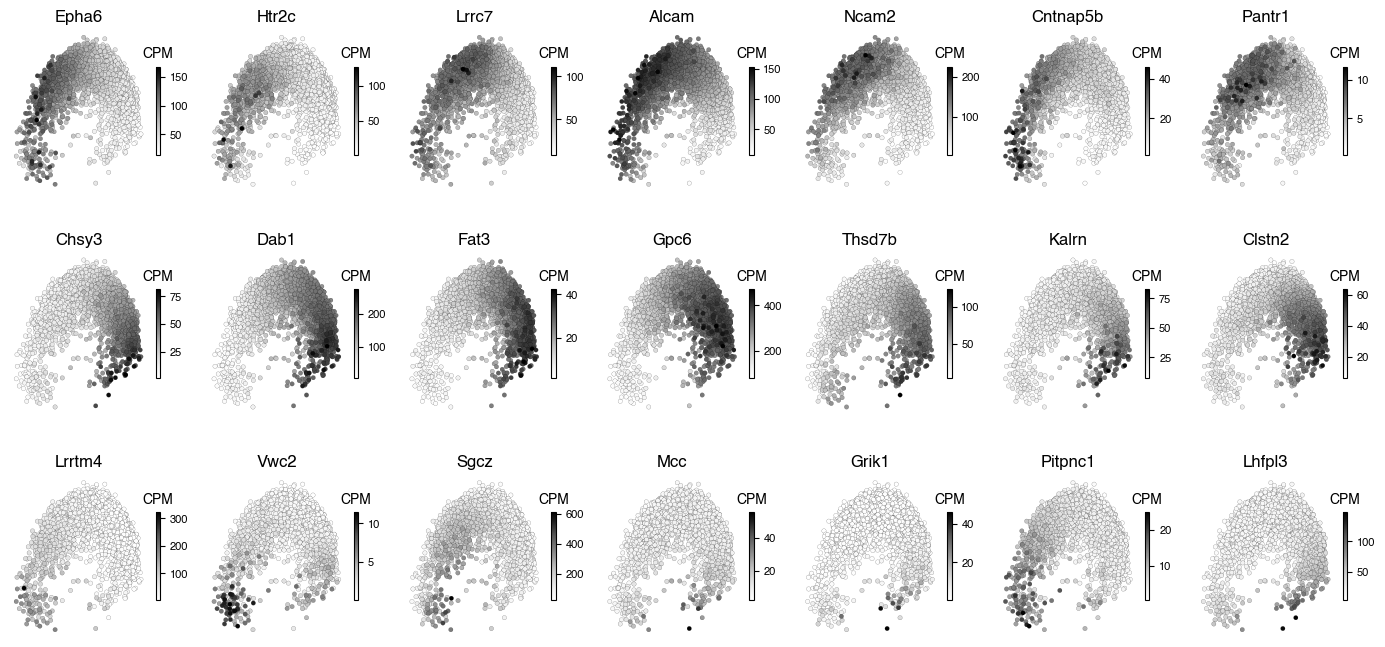

In [18]:
# Visualize Gene Expression Patterns on PCA
print("Visualizing gene expression patterns on PCA...")

s = 10
fig, axes = plt.subplots(3, T, figsize=(2*T, 7))

# Plot positive, negative, and u-shaped genes on PCA
for t in range(T):
    # Positive correlation genes
    ax = axes[0, t]
    ax.set_title(list(posgenes)[t])
    expr = adata_sc[:, list(posgenes)[t]].X.toarray().flatten()
    expr_order = np.argsort(expr)
    sca = ax.scatter(
        adata_sc.obsm['X_pca'][expr_order, 0],
        adata_sc.obsm['X_pca'][expr_order, 1],
        c=adata_sc.raw.X[expr_order,np.where(adata_sc.var_names==list(posgenes)[t])[0][0]]*cpm_scl,
        s=s, cmap='Greys',
        edgecolor='k', linewidth=0.1
    )    
    ax.set_aspect('equal')
    cbar = plt.colorbar(sca, shrink=0.4, orientation='vertical')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("CPM", ha='center', va='bottom')
    
    # Clean up appearance
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Negative correlation genes
    ax = axes[1, t]
    ax.set_title(list(neggenes)[t])
    expr = adata_sc[:, list(neggenes)[t]].X.toarray().flatten()
    expr_order = np.argsort(expr)
    sca = ax.scatter(
        adata_sc.obsm['X_pca'][expr_order, 0],
        adata_sc.obsm['X_pca'][expr_order, 1],
        c=adata_sc.raw.X[expr_order,np.where(adata_sc.var_names==list(neggenes)[t])[0][0]]*cpm_scl,
        s=s, cmap='Greys',
        edgecolor='k', linewidth=0.1
    )    
    ax.set_aspect('equal')
    cbar = plt.colorbar(sca, shrink=0.4, orientation='vertical')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("CPM", ha='center', va='bottom')
    
    # Clean up appearance
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # U-shaped genes
    ax = axes[2, t]
    ax.set_title(list(u_genes)[t])
    expr = adata_sc[:, list(u_genes)[t]].X.toarray().flatten()
    expr_order = np.argsort(expr)
    sca = ax.scatter(
        adata_sc.obsm['X_pca'][expr_order, 0],
        adata_sc.obsm['X_pca'][expr_order, 1],
        c=adata_sc.raw.X[expr_order,np.where(adata_sc.var_names==list(u_genes)[t])[0][0]]*cpm_scl,
        s=s, cmap='Greys',
        edgecolor='k', linewidth=0.1
    )    
    ax.set_aspect('equal')
    cbar = plt.colorbar(sca, shrink=0.4, orientation='vertical')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("CPM", ha='center', va='bottom')
    
    # Clean up appearance
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
save_figure("gene_patterns_pca")
plt.show()

Visualizing gene expression vs pseudocluster score...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_vs_pseudocluster.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_vs_pseudocluster.png


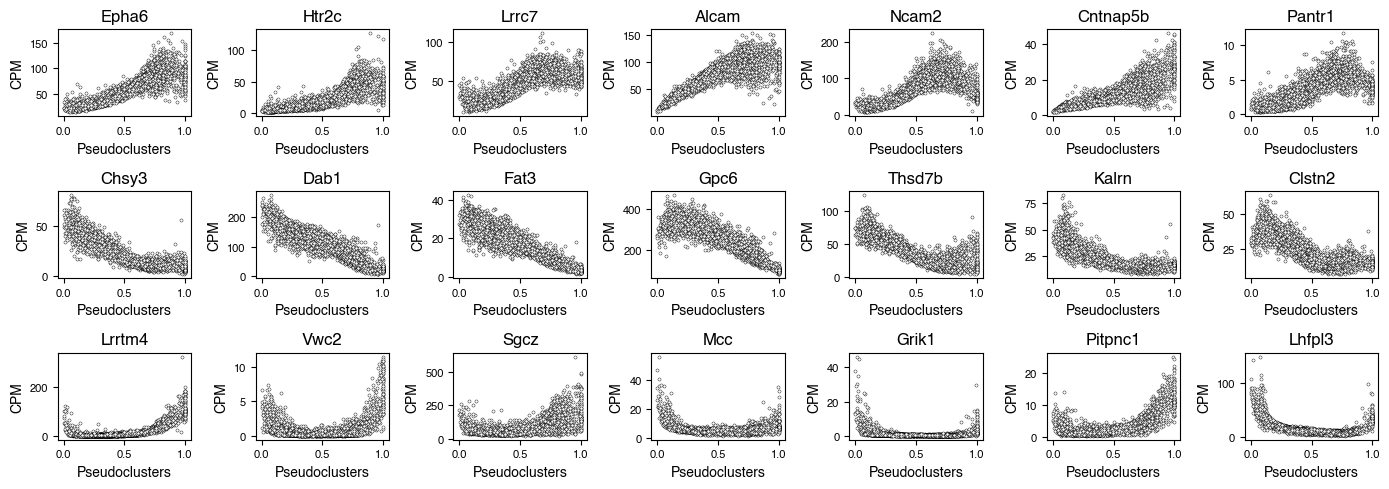

In [19]:
# Visualize Gene Expression vs Pseudocluster Score
print("Visualizing gene expression vs pseudocluster score...")

s = 5
fig, axes = plt.subplots(3, T, figsize=(2*T, 5))

# Plot gene expression vs pseudocluster score
for t in range(T):
    # Positive correlation genes
    ax = axes[0, t]
    ax.set_title(list(posgenes)[t])
    sca = ax.scatter(
        scores_0_1,
        adata_sc.raw.X[trajectory['order'],np.where(adata_sc.var_names==list(posgenes)[t])[0][0]]*cpm_scl, 
#         1e+6*adata_sc[trajectory['order'], list(posgenes)[t]].X.toarray(),
        s=s, color='white', edgecolor='k', linewidth=0.3
    )
    ax.set_ylabel('CPM')
    ax.set_xlabel('Pseudoclusters')
    
    # Negative correlation genes
    ax = axes[1, t]
    ax.set_title(list(neggenes)[t])
    sca = ax.scatter(
        scores_0_1, 
        adata_sc.raw.X[trajectory['order'],np.where(adata_sc.var_names==list(neggenes)[t])[0][0]]*cpm_scl, 
#         1e+6*adata_sc[trajectory['order'], list(neggenes)[t]].X.toarray(),
        s=s, color='white', edgecolor='k', linewidth=0.3
    )
    ax.set_ylabel('CPM')
    ax.set_xlabel('Pseudoclusters')
    
    # U-shaped genes
    ax = axes[2, t]
    ax.set_title(list(u_genes)[t])
    sca = ax.scatter(
        scores_0_1, 
        adata_sc.raw.X[trajectory['order'],np.where(adata_sc.var_names==list(u_genes)[t])[0][0]]*cpm_scl, 
#         1e+6*adata_sc[trajectory['order'], list(u_genes)[t]].X.toarray(),
        s=s, color='white', edgecolor='k', linewidth=0.3
    )
    ax.set_ylabel('CPM')
    ax.set_xlabel('Pseudoclusters')

fig.tight_layout()
save_figure("gene_vs_pseudocluster")
plt.show()

In [34]:
from matplotlib.colors import LinearSegmentedColormap
cmap_sele = plt.get_cmap(CMAP_NAME)
low_col = cmap_sele(0.0)   # RGBA for the "bottom" color
high_col = cmap_sele(1.0)  # RGBA for the "top" color
def make_edge_cmaps(base_cmap_name=CMAP_NAME):
    """Create two new colormaps based on the extremes of a given colormap."""
    cmap = plt.get_cmap(base_cmap_name)
    low = cmap(0.0)   # RGBA at bottom
    high = cmap(1.0)  # RGBA at top
    low_cmap = LinearSegmentedColormap.from_list("low_cmap", ["white", low])
    high_cmap = LinearSegmentedColormap.from_list("high_cmap", ["white", high])
    return low_cmap, high_cmap

low_cmap, high_cmap = make_edge_cmaps()

Visualizing selected example genes on PCA...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/example_genes_pca.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/example_genes_pca.png


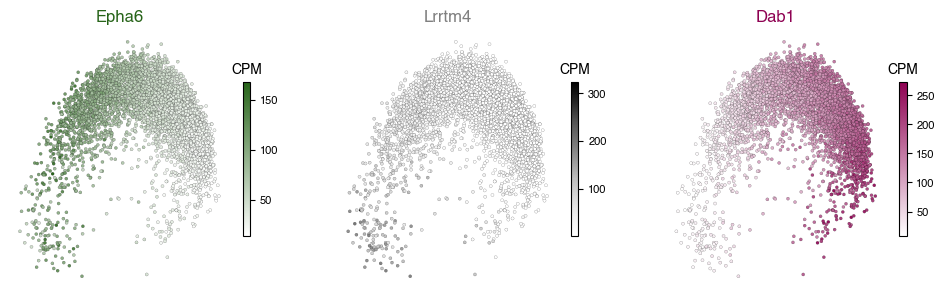

In [35]:
# Visualize Selected Example Genes on PCA
print("Visualizing selected example genes on PCA...")

showinggenelist = ['Epha6', 'Lrrtm4', 'Dab1']  # Three key genes
foocol = [high_col, 'gray', low_col]
cmapnames = [high_cmap, 'Grays', low_cmap, ]
s = 5

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for t, gene in enumerate(showinggenelist):
    ax = axes[t]
    ax.set_title(gene, color=foocol[t])
    sca = ax.scatter(
        adata_sc.obsm['X_pca'][:, 0],
        adata_sc.obsm['X_pca'][:, 1],
        c=adata_sc.raw.X[:,np.where(adata_sc.var_names==gene)[0][0]]*cpm_scl, 
        s=s, cmap=cmapnames[t], edgecolor='k', linewidth=0.1
    )
    ax.set_aspect('equal')
    cbar = plt.colorbar(sca, shrink=0.4, orientation='vertical')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.set_xlabel("CPM", ha='center', va='bottom')
    
    # Clean up appearance
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

save_figure("example_genes_pca")
plt.show()

Creating heatmap of gene expression along pseudoclusters...
Using 21 genes for heatmap
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_expression_heatmap.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/gene_expression_heatmap.png


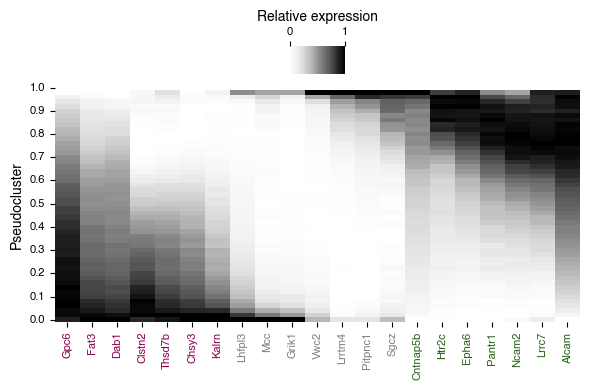

Row order for external use: [10, 9, 8, 13, 11, 7, 12, 20, 17, 18, 15, 14, 19, 16, 5, 1, 0, 6, 4, 2, 3]
All your genes for external use: ['Epha6', 'Htr2c', 'Lrrc7', 'Alcam', 'Ncam2', 'Cntnap5b', 'Pantr1', 'Chsy3', 'Dab1', 'Fat3', 'Gpc6', 'Thsd7b', 'Kalrn', 'Clstn2', 'Lrrtm4', 'Vwc2', 'Sgcz', 'Mcc', 'Grik1', 'Pitpnc1', 'Lhfpl3']


In [31]:
# Create Heatmap of Gene Expression along Pseudoclusters
print("Creating heatmap of gene expression along pseudoclusters...")

# Prepare gene list for heatmap
T = len(u_genes)
allyourgenes = list(posgenes)[:T] + list(neggenes)[:T] + list(u_genes)[:T]
print(f"Using {len(allyourgenes)} genes for heatmap")

# Process data for heatmap
inputheatmap = adata_sc[:, allyourgenes].X[trajectory['order']].copy()[np.argsort(scores_0_1)].T
ordered_data, row_order = heatmap.get_final_heatmap(inputheatmap)

# Set colors for different gene categories
tick_colors = []
for orig_idx in row_order:
    if orig_idx < T:
        tick_colors.append(high_col)  # Positive correlation genes
    elif orig_idx < 2*T:
        tick_colors.append(low_col)   # Negative correlation genes
    else:
        tick_colors.append('gray')  # U-shaped genes

# Create and style heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    ordered_data.T,
    cmap='Greys',
    cbar_kws={
        'location': 'top',
        'label': 'Relative expression',
        'shrink': 0.3,
        'aspect': 2,
        'fraction': 0.1
    }
)

# Set x-tick labels and colors
xtick_labels = [allyourgenes[l] for l in row_order]
xticks = plt.gca().get_xticks()
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=90)
for tick, color in zip(plt.gca().get_xticklabels(), tick_colors):
    tick.set_color(color)

# Set y-tick labels
plt.ylabel('Pseudocluster')
plt.gca().invert_yaxis()
plt.yticks(
    np.arange(11)*(ordered_data.shape[1]//10)+0.5, 
    np.around(np.linspace(0, 1, 11), 1), 
    rotation=0
)

plt.grid(False)
plt.tight_layout()
save_figure("gene_expression_heatmap")
plt.show()
# Export row order for integration with MERFISH data
print("Row order for external use:", row_order)
print("All your genes for external use:", allyourgenes)

In [23]:
# Analysis Summary
print("Analysis complete! All visualizations have been saved to:", fig_path)
print("\nSummary of analysis:")
print(f"- Analyzed {adata_sc.n_obs} cells with {adata_sc.n_vars} genes")
print(f"- Identified trajectory in {n_dims}-dimensional PCA space")
print(f"- Top positive correlation gene: {list(posgenes)[0]}")
print(f"- Top negative correlation gene: {list(neggenes)[0]}")
print(f"- Created visualizations for {T*3} genes across multiple projections")
print(f"- Generated heatmap with {len(allyourgenes)} genes ordered by expression pattern")

Analysis complete! All visualizations have been saved to: /root/capsule/lcne_transcriptomics/output/figures/snRNA

Summary of analysis:
- Analyzed 4895 cells with 1500 genes
- Identified trajectory in 10-dimensional PCA space
- Top positive correlation gene: Epha6
- Top negative correlation gene: Chsy3
- Created visualizations for 21 genes across multiple projections
- Generated heatmap with 21 genes ordered by expression pattern
